In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch Treasury yield data from Yahoo Finance
def fetch_yield_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data['Yield'] = data['Close'] / 100  # Convert to decimal
    return data[['Yield']]

# Define the date range
start_date = '2010-04-01'
end_date = '2024-07-17'

# Fetching data for Treasury yields
ten_year_yield = fetch_yield_data('^TNX', start_date, end_date)
twenty_year_yield = fetch_yield_data('^TYX', start_date, end_date)
thirty_year_yield = fetch_yield_data('^TYX', start_date, end_date)

# Define bond characteristics
bonds = {
    '10Y Treasury': {'maturity': 10, 'face_value': 1000, 'price': 950},
    '20Y Treasury': {'maturity': 20, 'face_value': 1000, 'price': 980},
    '30Y Treasury': {'maturity': 30, 'face_value': 1000, 'price': 1020}
}


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [25]:
# Function to calculate Macaulay duration
def macaulay_duration(bond, ytm):
    cash_flows = [bond['face_value'] * ytm] * bond['maturity']
    cash_flows[-1] += bond['face_value']  # Add face value to the last cash flow
    discounted_cf = [cf / (1 + ytm)**t for t, cf in enumerate(cash_flows, start=1)]
    pv = np.sum(discounted_cf)
    weights = np.array(discounted_cf) / pv
    durations = np.arange(1, bond['maturity'] + 1)
    macaulay_dur = np.sum(weights * durations)
    return macaulay_dur

# Function to calculate modified duration
def modified_duration(macaulay_dur, ytm):
    return macaulay_dur / (1 + ytm)

# Function to calculate dollar duration
def dollar_duration(modified_dur, bond):
    return modified_dur * bond['price']


In [26]:
# Function to calculate convexity
def convexity(bond, ytm):
    cash_flows = [bond['face_value'] * ytm] * bond['maturity']
    cash_flows[-1] += bond['face_value']  # Add face value to the last cash flow
    convexity_sum = sum([(t * (t + 1) * cf) / (1 + ytm)**(t + 2) for t, cf in enumerate(cash_flows, start=1)])
    return convexity_sum / (bond['price'] * (1 + ytm)**2)


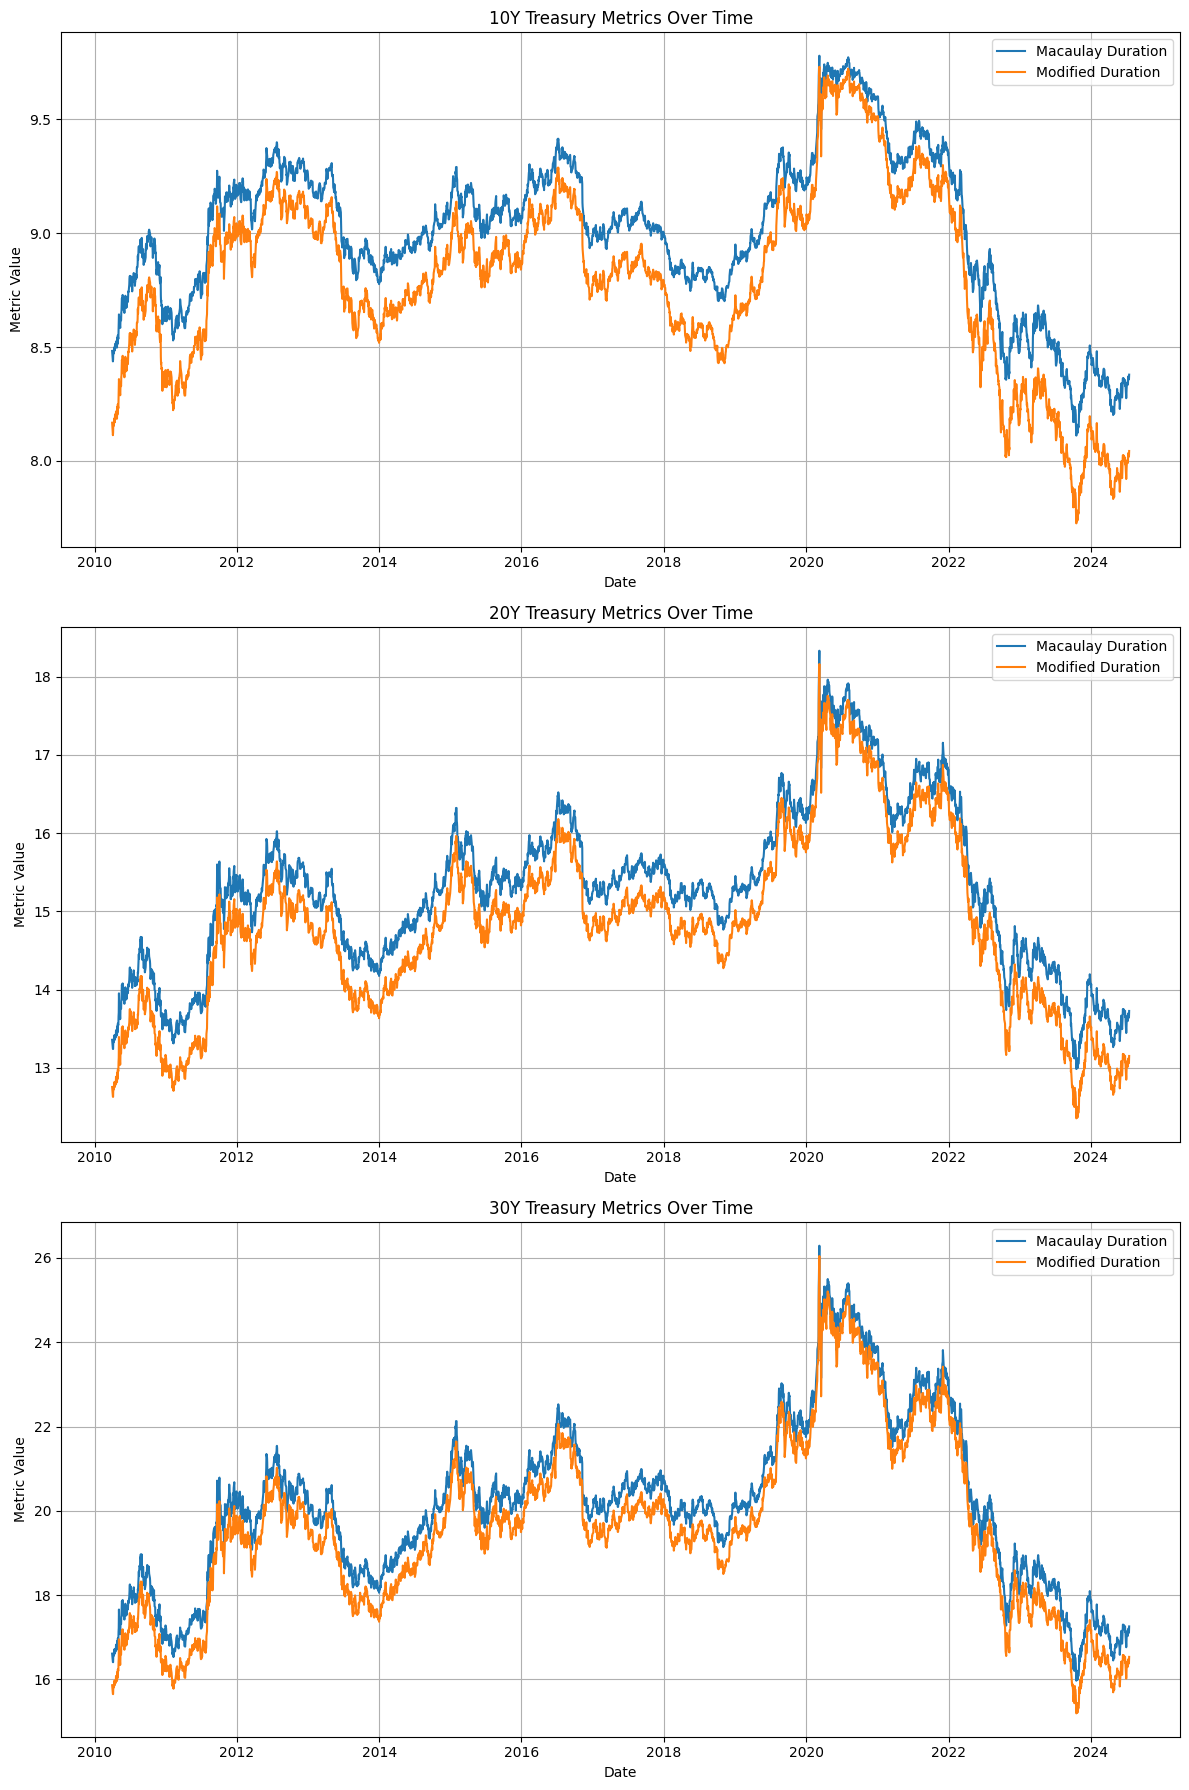

10Y Treasury:
  Macaulay Duration: 8.3791 years
  Modified Duration: 8.0439 years
  Dollar Duration: $7641.69
  Convexity: 77.3712

20Y Treasury:
  Macaulay Duration: 13.7264 years
  Modified Duration: 13.1511 years
  Dollar Duration: $12888.11
  Convexity: 214.6496

30Y Treasury:
  Macaulay Duration: 17.2563 years
  Modified Duration: 16.5331 years
  Dollar Duration: $16863.79
  Convexity: 352.8976



In [30]:
# Calculate and plot metrics for each bond
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
bond_names = ['10Y Treasury', '20Y Treasury', '30Y Treasury']
yields = [ten_year_yield, twenty_year_yield, thirty_year_yield]

for i, bond_name in enumerate(bond_names):
    bond = bonds[bond_name]
    bond_yields = yields[i].copy()  # Use copy to avoid modifying the original DataFrame
    macaulay_durations = []
    modified_durations = []
    dollar_durations = []
    convexities = []

    for ytm in bond_yields['Yield']:
        mac_dur = macaulay_duration(bond, ytm)
        mod_dur = modified_duration(mac_dur, ytm)
        dollar_dur = dollar_duration(mod_dur, bond)
        conv = convexity(bond, ytm)
        macaulay_durations.append(mac_dur)
        modified_durations.append(mod_dur)
        dollar_durations.append(dollar_dur)
        convexities.append(conv)

    bond_yields.loc[:, 'Macaulay Duration'] = macaulay_durations
    bond_yields.loc[:, 'Modified Duration'] = modified_durations
    bond_yields.loc[:, 'Dollar Duration'] = dollar_durations
    bond_yields.loc[:, 'Convexity'] = convexities

    # Plotting
    axs[i].plot(bond_yields.index, bond_yields['Macaulay Duration'], label='Macaulay Duration')
    axs[i].plot(bond_yields.index, bond_yields['Modified Duration'], label='Modified Duration')
  
    axs[i].set_title(f'{bond_name} Metrics Over Time')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Metric Value')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Calculate and print metrics for each bond
for i, bond_name in enumerate(bond_names):
    bond = bonds[bond_name]
    bond_yields = yields[i]
    latest_ytm = bond_yields['Yield'].iloc[-1]  # Use the latest yield to maturity

    mac_dur = macaulay_duration(bond, latest_ytm)
    mod_dur = modified_duration(mac_dur, latest_ytm)
    dollar_dur = dollar_duration(mod_dur, bond)
    conv = convexity(bond, latest_ytm)

    print(f"{bond_name}:")
    print(f"  Macaulay Duration: {mac_dur:.4f} years")
    print(f"  Modified Duration: {mod_dur:.4f} years")
    print(f"  Dollar Duration: ${dollar_dur:.2f}")
    print(f"  Convexity: {conv:.4f}")
    print()
